# This is Thanh's A* Search Algorithm

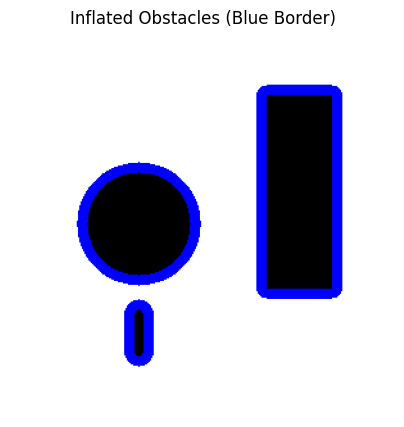

Free cells: 70571 Obstacle (inflated): 19429


In [73]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import heapq
import random

def show(img, title=None, cmap=None, size=5):
    plt.figure(figsize=(size, size))
    plt.imshow(img, cmap=cmap, origin='lower')
    if title: plt.title(title)
    plt.axis('off'); plt.show()

H, W = 300, 300
world = np.full((H, W), 255, np.uint8) # white background
occ   = np.zeros((H, W), np.uint8) # black free space

cv2.rectangle(occ, (200,250), (250,100), 1, -1) # filled rectangle
cv2.circle(occ, (100, 150), 40, 1, -1) # filled circle
cv2.line(occ, (100, 50), (100, 80), 1, 6) # thick line

k = 17 # kernel size
# Creating  a kernel (controls neighborhood size)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k)) # disk

# Dilation = expanding  obstacles (inflate boundaries)
infl = cv2.dilate(occ, kernel, iterations=1)

# Define start and goal locations
start = (50, 50)
goal = (275, 195)


FREE = (infl == 0)
# Visualize inflation
infl_rgb = np.dstack([world, world, world])
infl_rgb[occ == 1] = (0, 0, 0)
infl_rgb[(infl == 1) & (occ == 0)] = (0, 0, 255)

show(infl_rgb, "Inflated Obstacles (Blue Border)")
print("Free cells:", int(FREE.sum()), "Obstacle (inflated):", int((~FREE).sum()))



# Define start and goal locations

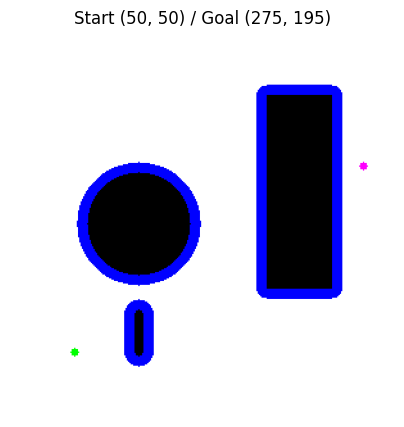

In [74]:
desired_start = (50, 50) #start
desired_goal  = (275, 195) #goal
# Snap start/goal to nearest FREE cell if needed
def nearest_free(pt, FREE):
    x, y = pt
    if 0 <= x < W and 0 <= y < H and FREE[y, x]:
        return pt
    ys, xs = np.where(FREE) # all free cells
    if len(xs) == 0:
        raise ValueError("No free space available.")
    idx = np.argmin((xs - x)**2 + (ys - y)**2)
    return (int(xs[idx]), int(ys[idx]))
#
start = nearest_free(desired_start, FREE)
goal  = nearest_free(desired_goal,  FREE)

pts_rgb = infl_rgb.copy()
cv2.circle(pts_rgb, start, 3, (0,255,0), -1)
cv2.circle(pts_rgb, goal,  3, (255,0,255), -1)
show(pts_rgb, f"Start {start} / Goal {goal}")


In [75]:
STEP = 1 # grid step size
# Create lattice graph nodes on FREE space
lattice_nodes = [(x, y) for y in range(0, H, STEP) for x in range(0, W, STEP) if FREE[y, x]]
node_set = set(lattice_nodes)

In [76]:

MOVES_4 = [(1,0),(-1,0),(0,1),(0,-1)] # 8-connectivity
# Get neighbors on the grid (FREE space)

def in_bounds(x, y): 
    return 0 <= x < W and 0 <= y < H

# Get neighbors on the grid (FREE space)
def neighbors_on_grid(x, y):
    for dx, dy in MOVES_4:
        nx, ny = x + dx, y + dy
        if in_bounds(nx, ny) and FREE[ny, nx]:
            yield (nx, ny)

In [77]:
# Create adjacency list for the lattice graph
adj_list = defaultdict(list)
for (x, y) in lattice_nodes:
    for (nx, ny) in neighbors_on_grid(x, y):
        if (nx, ny) in node_set:
            adj_list[(x, y)].append((nx, ny))

#
V = len(adj_list) # number of vertices
E = sum(len(n) for n in adj_list.values()) // 2 # undirected edges
avg_deg = 0 if V == 0 else (2*E)/V # average degree
print(f"Adjacency List: V={V}, E≈{E}, avg degree≈{avg_deg:.2f}")
for k in list(adj_list.keys())[:5]:
    print(k, "->", adj_list[k][:8])


Adjacency List: V=70571, E≈140038, avg degree≈3.97
(0, 0) -> [(1, 0), (0, 1)]
(1, 0) -> [(2, 0), (0, 0), (1, 1)]
(2, 0) -> [(3, 0), (1, 0), (2, 1)]
(3, 0) -> [(4, 0), (2, 0), (3, 1)]
(4, 0) -> [(5, 0), (3, 0), (4, 1)]


In [78]:
# Create a parent map to reconstruct path

parent =  defaultdict(tuple)

# Create a g function

COST = 1 # uniform cost

g = defaultdict(int)

def g_cost(n):
    p = parent[n]
    return g[p] + COST

In [ ]:
#Heuristic function (Manhattan distance)
def heuristic(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return abs(x1 - x2) + abs(y1 - y2) # Manhattan distance

#Create a heap priority queue
open = []

heapq.heappush(open, (heuristic(start,goal), start)) # (priority, node)

g[start] = 0

# A* Search Algorithm
while open:
    _, current = heapq.heappop(open)
    if current == goal:
        print("Goal reached!")
        break
    for neighbor in adj_list[current]:
        step = g_cost(current) + COST
        if neighbor not in g or step < g[neighbor]:
            parent[neighbor] = current
            g[neighbor] = step
            f_score = step + heuristic(neighbor, goal)
            heapq.heappush(open, (f_score, neighbor))

# Reconstruct path from parent
path_nodes = []
path_nodes.append(current)
while current != start:
    path_nodes.append(parent[current])
    current = parent[current] 

Goal reached!


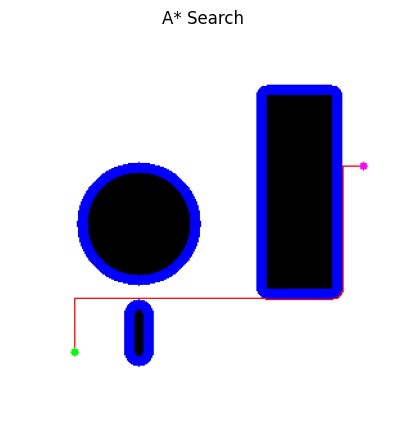

In [ ]:
# Adding the path for visualization
path_rgb = infl_rgb.copy()
if path_nodes:
    for (x, y) in path_nodes:
        path_rgb[y, x] = (255, 0, 0)
    cv2.circle(path_rgb, start, 3, (0,255,0), -1)
    cv2.circle(path_rgb, goal, 3, (255,0,255), -1)
    show(path_rgb, "A* Search")
else:
    show(infl_rgb, "No path found — try smaller STEP or less inflation")
